In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import scipy.optimize as spo
import scipy.stats as sts
plt.style.use('seaborn')

#### Unimportant Warnings

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

## New HDF5 Data Import
The long waiting time has been relegated to a different notebook, and now this notebook imports the clean data directly from an HDF5 file.

In [3]:
run_label = '2020_11_09' ## Change this to look at different runs
hdf_name = '{}_clean_data.h5'.format(run_label)

In [4]:
gases = ['H2', 'H2O', 'N2', 'O2', 'CO2']
gas_tables = [] # appendable list of gas data tables from HDF5

for gas in gases:
    gas_tables.append(pd.read_hdf(hdf_name, key=gas))

### Curve Fitting
$$p(t,T) = A\cdot \exp\left(-\frac{b}{T}\right)\cdot\exp\left(-c\cdot t\cdot \exp\left(-\frac{b}{T}\right)\right)$$

In [5]:
def pressure_fit(tT, A, b, c):
    # (k,M) array if there are k predictors
    factor = np.exp(-1.0*b/tT[1])
    return A * factor * np.exp(-1.0*c*tT[0]*factor)

In [6]:
#O2_jump1 = O2_final_data[O2_final_data['Datetime'].between(51000, 65000)]

In [7]:
jump_bounds = [[51000, 64600],[64400, 89500],[90000, 110200],[110200, 150000]]
init_params = [7, 5900, 800]

In [8]:
def jump_analysis(data_table, bounds, params):
    """Output the time, pressure data, and fit values for one CO2 jump defined
    by the bounds.
    
    Arguments
    bounds: a two-element list of [lower bound, upper bound]
    params: a three-element list of [A, b, c] from the pressure_fit function"""

    jump_table = data_table[data_table['exp_time'].between(bounds[0], bounds[1])]
    jump_time_start = jump_table['exp_time'].unique()[0]
    jump_table['jump_time'] = jump_table['exp_time'] - jump_time_start
    time_temp_vals = jump_table[['jump_time', 'temp_est']].T.to_numpy()
    fit_jump = jump_table['pressure'].to_numpy()
    popt, pcov = spo.curve_fit(pressure_fit, time_temp_vals, fit_jump, p0=params, maxfev=100000)
    jump_fits = pressure_fit(time_temp_vals, popt[0], popt[1], popt[2])
    
    return jump_table['exp_time'], jump_table['CO2_Pressure'], jump_fits, popt, pcov, time_temp_vals

In [9]:
def alt_jump_analysis(data_table, bounds, params):
    """Output the time, pressure data, and fit values for one CO2 jump defined
    by the bounds.
    
    Arguments
    bounds: a two-element list of [lower bound, upper bound]
    params: a three-element list of [A, b, c] from the pressure_fit function"""

    jump_table = data_table[data_table['exp_time'].between(bounds[0], bounds[1])]
    jump_time_start = jump_table['exp_time'].unique()[0]
    jump_table['jump_time'] = jump_table['exp_time'] - jump_time_start
    time_temp_vals = jump_table[['jump_time', 'ch1_lerp']].T.to_numpy()
    fit_jump = jump_table['pressure'].to_numpy()
    popt, pcov = spo.curve_fit(pressure_fit, time_temp_vals, fit_jump, p0=params, maxfev=100000)
    jump_fits = pressure_fit(time_temp_vals, popt[0], popt[1], popt[2])
    
    return jump_table['exp_time'], jump_table['pressure'], jump_fits, popt, pcov, time_temp_vals

In [10]:
jump_bounds[1][0]

64400

In [11]:
def fitting_scan(data_table, bounds, Ea_range, D_range, num_values):
    
    Ea_vals = np.linspace(Ea_range[0], Ea_range[1], num=num_values)
    D_vals = np.linspace(D_range[0], D_range[1], num=num_values)
    #Ea_D_array = np.transpose([np.tile(Ea_vals, len(D_vals)), np.repeat(D_vals, len(Ea_vals))])
    
    gas_ssq = np.zeros((Ea_vals.shape[0], D_vals.shape[0]))
    
    for idx, jump_bound in enumerate(bounds):
        jump_table = data_table[data_table['exp_time'].between(jump_bound[0], jump_bound[1])]
        jump_time_start = jump_table['exp_time'].unique()[0]
        jump_table['jump_time'] = jump_table['exp_time'] - jump_time_start
        time_temp_vals = jump_table[['jump_time', 'ch1_lerp']].T.to_numpy()
        fit_jump = jump_table['pressure'].to_numpy()
        for x, Ea in enumerate(Ea_vals):
            for y, D in enumerate(D_vals):
                popt, pcov = spo.curve_fit(lambda tT, A: pressure_fit(tT, A, Ea, D),
                                       time_temp_vals, fit_jump, p0=[7], maxfev=100000)
                jump_fits = pressure_fit(time_temp_vals, popt[0], Ea, D)
                resids = jump_fits - fit_jump
                resids = resids
                ssq = np.dot(resids, resids)/(7.5e-10**2)
                gas_ssq[x, y] += ssq
    
    return Ea_vals, D_vals, gas_ssq

In [12]:
%%capture
Ea_range = [1.85e+03, 1.92e+03]
D_range = [5.3e-03, 5.4e-03]
CO2_Ea, CO2_D, CO2_ssq = fitting_scan(gas_tables[4], jump_bounds, Ea_range, D_range, num_values=75)

In [13]:
%%capture
Ea_range = [5000, 7000]
D_range = [0, 1]
O2_Ea, O2_D, O2_ssq = fitting_scan(gas_tables[3], jump_bounds, Ea_range, D_range, num_values=75)

In [14]:
pd.DataFrame(data=CO2_ssq)

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,73993.775506,74096.133925,74198.611045,74301.206859,74403.921357,74506.754531,74609.706371,74712.776870,74815.966017,74919.273805,...,80893.588108,81003.643808,81113.817634,81224.109579,81334.519632,81445.047786,81555.694030,81666.458357,81777.340757,81888.341220
1,72801.458316,72902.130855,73002.921503,73103.830250,73204.857087,73306.002007,73407.265000,73508.646058,73610.145172,73711.762333,...,79590.458476,79698.789928,79807.238921,79915.805445,80024.489492,80133.291052,80242.210117,80351.246677,80460.400725,80569.672252
2,71628.815761,71727.814247,71826.930248,71926.163758,72025.514767,72124.983267,72224.569250,72324.272706,72424.093627,72524.032005,...,78307.776741,78414.395915,78521.132045,78627.985121,78734.955136,78842.042080,78949.245945,79056.566721,79164.004401,79271.558976
3,70475.711119,70573.047315,70670.500438,70768.070480,70865.757432,70963.561286,71061.482033,71159.519666,71257.674175,71355.945552,...,77045.402232,77150.321036,77255.356212,77360.507753,77465.775650,77571.159895,77676.660478,77782.277392,77888.010627,77993.860175
4,69342.008371,69437.693981,69533.495931,69629.414213,69725.448819,69821.599740,69917.866968,70014.250494,70110.750311,70207.366409,...,75803.194992,75906.425272,76009.771345,76113.233202,76216.810836,76320.504237,76424.313397,76528.238308,76632.278961,76736.435347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,31179.978631,31189.728232,31199.560307,31209.474854,31219.471868,31229.551346,31239.713285,31249.957681,31260.284530,31270.693830,...,31985.096038,32000.199145,32015.384496,32030.652087,32046.001915,32061.433977,32076.948268,32092.544785,32108.223524,32123.984483
71,31071.180637,31079.935694,31088.772784,31097.691904,31106.693050,31115.776218,31124.941406,31134.188610,31143.517826,31152.929050,...,31810.736305,31824.816265,31838.978031,31853.221599,31867.546966,31881.954127,31896.443080,31911.013820,31925.666345,31940.400651
72,30974.063674,30981.832221,30989.682361,30997.614092,31005.627409,31013.722309,31021.898789,31030.156846,31038.496476,31046.917675,...,31648.583982,31661.648960,31674.795308,31688.023021,31701.332096,31714.722530,31728.194319,31741.747459,31755.381948,31769.097781
73,30888.534829,30895.324852,30902.196031,30909.148362,30916.181843,30923.296470,30930.492239,30937.769147,30945.127191,30952.566368,...,31498.543084,31510.601198,31522.740246,31534.960225,31547.261132,31559.642963,31572.105715,31584.649385,31597.273968,31609.979462


In [15]:
CO2_min_index = np.unravel_index(np.argmin(CO2_ssq), CO2_ssq.shape)
CO2_best_Ea = CO2_Ea[CO2_min_index[0]]
CO2_best_D = CO2_D[CO2_min_index[1]]

In [16]:
CO2_best_D

0.0053

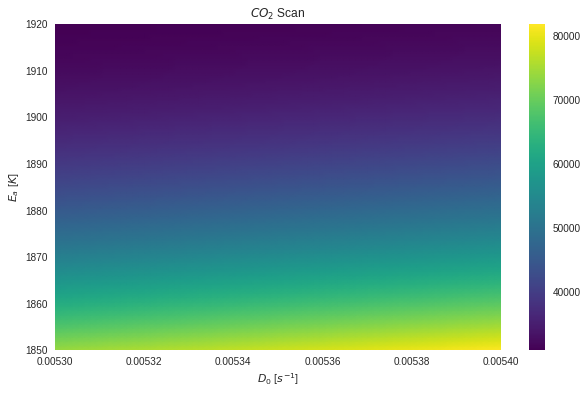

In [26]:
fig, ax = plt.subplots(figsize=(10,6))
CO2_heat = ax.pcolormesh(CO2_D, CO2_Ea, CO2_ssq, cmap='viridis', shading='gouraud')
ax.set_title('$CO_2$ Scan')
ax.set_ylabel('$E_a$ [$K$]')
ax.set_xlabel('$D_0$ [$s^{-1}$]')
plt.colorbar(CO2_heat)

#O2_heat = ax[1].pcolormesh(np.log(O2_ssq), cmap='viridis', shading='gouraud')
#ax[1].set_title('$O_2$ Scan')
#ax[1].set_ylabel('$E_a$')
#ax[1].set_xlabel('$D_0$')

fig.savefig('images/co2_scan_2020_11_09.png', dpi=144)
plt.show()

In [23]:
%%capture
alt_jump_outs = []
# Warnings incoming. Not a problem
for idx, gas in enumerate(gases):
    gas_jumps = []
    for listed_jump in jump_bounds:
        gas_jump_out = alt_jump_analysis(gas_tables[idx], listed_jump, init_params)
        gas_jumps.append(gas_jump_out)
    alt_jump_outs.append(gas_jumps)

The code from the above cell creates a 3-layer nested list.
- First index: which gas
- Second index: which jump
- Third index: times, pressures, fit pressures, fitted parameter values, covariance matrix, time-and-temperature table

In [24]:
# Sample output: the popt values from CO2 jump 1
alt_jump_outs[4][0][3]

array([6.86386181e-05, 1.89812147e+03, 5.34528993e-03])

### Plotting

In [ ]:
CO2_Ea_vals = np.array([alt_jump_outs[4][0][3][1], alt_jump_outs[4][1][3][1], alt_jump_outs[4][2][3][1], alt_jump_outs[4][3][3][1]])
CO2_Ea_errs = np.array([alt_jump_outs[4][0][4][1][1], alt_jump_outs[4][1][4][1][1], alt_jump_outs[4][2][4][1][1], alt_jump_outs[4][3][4][1][1]])
CO2_D_vals = np.array([alt_jump_outs[4][0][3][2], alt_jump_outs[4][1][3][2], alt_jump_outs[4][2][3][2], alt_jump_outs[4][3][3][2]])
CO2_D_errs = np.array([alt_jump_outs[4][0][4][2][2], alt_jump_outs[4][1][4][2][2], alt_jump_outs[4][2][4][2][2], alt_jump_outs[4][3][4][2][2]])

k_B = 8.617e-5 # Boltzmann constant in eV/K

fig, ax = plt.subplots(figsize=(10,6))
ax.errorbar(CO2_D_vals, CO2_Ea_vals*k_B, yerr=CO2_Ea_errs*k_B, xerr=CO2_D_errs, fmt='o', color='navy')
ax.scatter(CO2_best_D, CO2_best_Ea*k_B, color='red')

ax.set_title('CO2 Measured Activation Energies by Jump')
ax.set_xlabel('$c$ $\\left[s^{-1}\\right]$')
ax.set_ylabel('Activation Energy [eV]')
ax.set_xscale('log')

fig.savefig('images/co2_Ea_vals_2020_11_09.png', dpi=144)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
for i in range(4):
    ax.scatter(alt_jump_outs[4][i][0]/3600, alt_jump_outs[4][i][1], marker='.')
    ax.plot(alt_jump_outs[4][i][0]/3600, alt_jump_outs[4][i][2], color='black')

#for idx, guess in enumerate(CO2_Ea_guesses):
#    ax.plot(CO2_jump4_alt[0]/3600, CO2_jump4_guessfits[idx], label='Ea = {}'.format(guess))
ax.set_ylabel('Partial Pressure [torr]')
ax.set_xlabel('Experiment Time [hours]')
ax.set_title('$CO_2$ Jumps Plot and Fit')
#ax.legend()
ax.set_yscale('log')
fig.savefig('images/co2_all_fits_2020_11_09.png', dpi=144)

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
for i in range(len(jump_bounds)):
    ax.scatter(alt_jump_outs[3][i][0]/3600, alt_jump_outs[3][i][1], marker='.')
    ax.plot(alt_jump_outs[3][i][0]/3600, alt_jump_outs[3][i][2], color='black')

#for idx, guess in enumerate(CO2_Ea_guesses):
#    ax.plot(CO2_jump4_alt[0]/3600, CO2_jump4_guessfits[idx], label='Ea = {}'.format(guess))
ax.set_ylabel('Partial Pressure [torr]')
ax.set_xlabel('Experiment Time [hours]')
ax.set_title('$O_2$ Jumps Plot and Fit')
#ax.legend()
ax.set_yscale('log')
fig.savefig('images/o2_all_fits_2020_11_09.png', dpi=144)

plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.scatter(alt_jump_outs[4][3][0]/3600, alt_jump_outs[4][3][1], marker='.', color='blue', label='RGA Output')
ax1.plot(alt_jump_outs[4][3][0]/3600, alt_jump_outs[4][3][2], color='red', label='RGA Fit')

ax1.set_title('Jump 4 RGA Output (Fit to Top Channel)')
ax1.set_xlabel('Experiment Time [hours]')
ax1.set_ylabel('Pressure [torr]')
#ax1.set_yscale('log')

plt.savefig('images/co2_4_alt_2020_11_09.png', dpi=144)

plt.show()

In [ ]:
jump4_temps = gas_tables[4][gas_tables[4]['exp_time'].between(jump_bounds[3][0], jump_bounds[3][1])][['ch1_lerp', 'ch2_lerp', 'mean_temp']]

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.scatter(alt_jump_outs[4][3][0]/3600, alt_jump_outs[4][3][1], marker='.', color='black', label='RGA Output')
ax1.plot(alt_jump_outs[4][3][0]/3600, alt_jump_outs[4][3][2], color='red', label='RGA Fit')

ax2 = ax1.twinx()

ax2.plot(alt_jump_outs[4][3][0]/3600, jump4_temps['ch2_lerp'], color='darkorange', label='Bottom Channel')
ax2.plot(alt_jump_outs[4][3][0]/3600, jump4_temps['mean_temp'], color='purple', label='Two-Channel Mean')
ax2.plot(alt_jump_outs[4][3][0]/3600, jump4_temps['ch1_lerp'], color='darkblue', label='Top Channel')

ax1.set_title('Jump 4 RGA Output and Temperature Readings')
ax1.set_xlabel('Experiment Time [hours]')
ax1.set_ylabel('Pressure [torr]')
ax1.legend(loc='right')

ax2.set_ylabel('Temperature [K]')
ax2.legend(loc='lower center')

plt.savefig('images/co2_4_fit_2020_11_09.png', dpi=144)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(alt_jump_outs[4][3][0]/3600, alt_jump_outs[4][3][1] - alt_jump_outs[4][3][2], marker='.', color='maroon', label='Fit from Top Channel')
ax.set_ylabel('Partial Pressure Residual [torr]')
ax.set_xlabel('Experiment Time [hours]')
ax.axhline(color='k')
ax.set_title('$CO_2$ Jump 4 Residuals')
ax.legend()

fig.savefig('images/co2_4_resid_2020_11_09.png', dpi=144)

plt.show()

In [ ]:
#CO2_data['Pressure'].iloc[np.array(CO2_times.between(50000,110000))]

### Finding the Bounds of Each Jump

In [ ]:
bnds = [110200, 150000]

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(gas_tables[4]['exp_time'].iloc[np.array(gas_tables[4]['exp_time'].between(bnds[0],bnds[1]))],
           gas_tables[4]['pressure'].iloc[np.array(gas_tables[4]['exp_time'].between(bnds[0],bnds[1]))], marker='.', label='Carbon Dioxide')
ax.set_title('RGA Output for $CO_2$')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Partial Pressure [torr]')
ax.legend()
ax.set_yscale('log')

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

for idx, gas in enumerate(gases):
    ax.scatter(gas_tables[idx]['exp_time'], gas_tables[idx]['pressure'], marker='.', label=gas)

ax.set_title('RGA Output for Impurities')
ax.set_xlabel('Time')
ax.set_ylabel('Partial Pressure (torr)')
ax.legend()
ax.set_yscale('log')

#ax[1].plot(temp_times, pd.to_numeric(Temp['CH1']), label='Channel 1')
#ax[1].plot(temp_times, pd.to_numeric(Temp['CH2']), label='Channel 2', color='darkorange')
#ax[1].set_title('Temperature over Time from Top and Bottom Channels')
#ax[1].set_xlabel('Time [sec]')
#ax[1].set_ylabel('Temperature (C)')
#ax[1].legend()

fig.savefig('plot_out_{}.png'.format(run_label), dpi=300)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(gas_tables[4]['exp_time'], gas_tables[4]['ch1_lerp'], label='Interpolated CH1', color='darkblue')
ax.plot(gas_tables[4]['exp_time'], gas_tables[4]['ch2_lerp'], label='Interpolated CH2', color='darkorange')
ax.plot(gas_tables[4]['exp_time'], gas_tables[4]['mean_temp'], label='Average Interpolated', color='purple')
ax.legend()

plt.show()

In [ ]:
#IO.RemoveZipDir()